In [51]:
import pandas as pd
import numpy as np
from itertools import combinations
from numpy import transpose as t
from numpy.linalg import inv
import math
from scipy.special import gamma
from scipy.special import loggamma
from numpy import log

In [52]:
data = pd.read_csv("data.csv")

In [53]:
data.head()

,PC1,PC2,Claim_price,Auction_count,Hammer_price,Final_First_auction_data,ad_si_0,ad_si_1,ad_si_2,ad_si_3,Appr_0,Appr_1,Appr_2,서울,transformed_Hammer_price,skyscraper
0,2.82322,-1.43572,1766037301,2,760000000,35,0,1,0,0,0,0,1,0,175.39407,30
1,1.27894,-2.64661,152946867,2,971889999,35,0,1,0,0,0,0,1,0,182.98579,51
2,-0.53006,2.63166,11326510,3,93399999,77,0,0,0,1,0,0,1,0,121.88877,30
3,-0.70646,0.08109,183581724,2,256899000,105,0,0,0,1,0,0,1,0,145.38769,30
4,-0.53385,0.98682,45887671,2,158660000,28,0,0,0,1,0,0,1,0,133.70034,30


In [54]:
X = data.drop(['Hammer_price','transformed_Hammer_price','ad_si_3','Appr_2'],axis=1)
y = data['transformed_Hammer_price']

In [55]:
X.head()

,PC1,PC2,Claim_price,Auction_count,Final_First_auction_data,ad_si_0,ad_si_1,ad_si_2,Appr_0,Appr_1,서울,skyscraper
0,2.82322,-1.43572,1766037301,2,35,0,1,0,0,0,0,30
1,1.27894,-2.64661,152946867,2,35,0,1,0,0,0,0,51
2,-0.53006,2.63166,11326510,3,77,0,0,0,0,0,0,30
3,-0.70646,0.08109,183581724,2,105,0,0,0,0,0,0,30
4,-0.53385,0.98682,45887671,2,28,0,0,0,0,0,0,30


In [56]:
#scaling
for i in X.columns:
    m = np.mean(X[i])
    s = np.std(X[i])
    X[i] = X[i].apply(lambda x : (x-m)/s)

In [57]:
class Model:
    
    def z_function(self,data,category_index):
        p = data.shape[1]
        category = [i for i in range(p)]
        Ncategory = []
        for i in category_index:
            Ncategory.append(i)
            for j in i:
                category.remove(j)
        x = [[i] for i in category]
        for i in Ncategory:
            x.append(i)
        result = []
        cnt=0
        for i in range(len(x)): 
            count = len(list(combinations(x,i+1))) 
            for j in range(count):   
                z = [0]*p
                for k in range(i+1):
                    if len(list(combinations(x,i+1))[j][k]) == 1: #(1,2)
                        z[list(combinations(x,i+1))[j][k][0]] = 1
                    else:
                        for m in range(len(list(combinations(x,i+1))[j][k])):#(1,(2,3,4))
                            z[list(combinations(x,i+1))[j][k][m]] = 1
                result.append(z)
        return result
    
    def sig(self,X,y):
        X = np.array(X)
        n = X.shape[0]
        yhat = X@inv(t(X)@X)@t(X)@y
        res = y-yhat
        return sum(res**2)/n
        
    
    def posterior(self,X,y,category_index,g):
        nu0 = 1 
        z = Model.z_function(self,X,category_index)
        y = np.array(y)
        l = []
        for i in z:
            i = np.array(i)
            Xz = X.iloc[:,np.where(i==1)[0]]
            n,p = Xz.shape
            Xz = np.array(Xz)
            sig0 = Model.sig(self,Xz,y)
            ssr = t(y)@(np.eye(n)-g/(g+1)*Xz@inv(t(Xz)@Xz)@t(Xz))@y
            loglikelihood = (-n/2)*log(np.pi)+loggamma((nu0+n)/2)-loggamma(nu0/2)-p/2*log(1+g)+nu0/2*log(nu0*sig0)-(nu0+n)/2*log(nu0*sig0+ssr)
            l.append(loglikelihood)
        l = l/sum(l)
        return l

In [58]:
m = Model()

In [59]:
z = m.z_function(X,[[5,6,7],[8,9]])

In [60]:
posterior = m.posterior(X,y,[[5,6,7],[8,9]],X.shape[0])

In [61]:
result = pd.DataFrame()
result['model'] = z
result['posterior'] = posterior

In [62]:
result.head()

,model,posterior
0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.00195
1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.00196
2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.00196
3,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",0.00196
4,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",0.00196


In [63]:
np.argmax(posterior)

509

In [64]:
result.iloc[np.argmax(posterior),:]

model        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
posterior                                 0.00196
Name: 509, dtype: object

In [65]:
from statsmodels.formula.api import ols

In [66]:
res = ols('transformed_Hammer_price~PC2+Claim_price+Auction_count+Final_First_auction_data+ad_si_0+ad_si_1+ad_si_2+Appr_0+Appr_1+서울+skyscraper',data=data).fit()

In [67]:
X['PC1']=1
X.rename(columns={'PC1':'intercept'})
Xz = X.iloc[:,:]
n=Xz.shape[0]
g=n
s0 = res.mse_resid
nu0=1
ssr=t(y).dot(np.eye(n)-Xz.dot(inv(t(Xz).dot(Xz)).dot(t(Xz)))*g/(g+1)).dot(y)
beta=res.params[:]

In [68]:
from scipy.stats import gamma
from scipy.stats import multivariate_normal

BETA = []

for i in range(1000):
    precision_MC = gamma.rvs(a = nu0+n, scale = (nu0+n)/(nu0*s0+ssr),size=1)
    cov_MC = 1/precision_MC * inv(t(Xz).dot(Xz))
    beta_MC = multivariate_normal.rvs(mean = beta * g/(g+1), cov=cov_MC*g/(g+1),size=1)
    BETA.append(beta_MC)
    
pd.DataFrame(BETA).mean()

0    87.36875
1    -1.63248
2    -0.00063
3    -2.94475
4     0.00462
5    24.10009
6     9.48722
7    30.64569
8     7.22272
9    29.94743
10   14.34822
11    1.80355
dtype: float64

In [69]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     transformed_Hammer_price   R-squared:                       0.544
Model:                                  OLS   Adj. R-squared:                  0.541
Method:                       Least Squares   F-statistic:                     200.0
Date:                      Wed, 02 Jun 2021   Prob (F-statistic):          1.16e-304
Time:                              14:58:48   Log-Likelihood:                -7501.3
No. Observations:                      1855   AIC:                         1.503e+04
Df Residuals:                          1843   BIC:                         1.509e+04
Df Model:                                11                                         
Covariance Type:                  nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   87.4158      7.414     11.791      0.000      72.875     101.957
PC2                         -1.6335      0.345     -4.733      0.000      -2.310      -0.957
Claim_price               1.024e-09   2.94e-10      3.485      0.001    4.48e-10     1.6e-09
Auction_count               -2.9464      0.424     -6.950      0.000      -3.778      -2.115
Final_First_auction_data     0.0049      0.002      1.992      0.046    7.56e-05       0.010
ad_si_0                     24.1131      1.288     18.717      0.000      21.586      26.640
ad_si_1                      9.4923      0.799     11.878      0.000       7.925      11.060
ad_si_2                     30.6621      1.627     18.842      0.000      27.471      33.854
Appr_0                       7.2263      1.893      3.818      0.000       3.514      10.938
Appr_1                      29.9635     13.958      2.147      0.032       2.589      57.338
서울                          14.3558      0.750     19.152      0.000      12.886      15.826
skyscraper                   1.8042      0.242      7.443      0.000       1.329       2.280
==============================================================================
Omnibus:                      197.368   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              344.788
Skew:                          -0.718   Prob(JB):                     1.35e-75
Kurtosis:                       4.548   Cond. No.                     5.01e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.01e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [70]:
tdat = pd.read_csv("final_test1.csv",encoding='cp949')

In [71]:
tdat.head()

,PC1,PC2,Claim_price,Auction_count,Hammer_price,Final_First_auction_data,ad_si_0,ad_si_1,ad_si_2,Appr_0,Appr_1,서울,skyscraper,transformed_Hammer_price
0,-0.01812,-1.28331,1087000000,7,0,1058,0,0,0,0,0,0,30,136.40678
1,-0.13874,-1.14894,1087000000,6,0,1030,0,0,0,0,0,0,30,138.33211
2,-0.02124,-1.27999,1087000000,7,0,1058,0,0,0,0,0,0,30,136.36724
3,-0.02124,-1.27999,1087000000,7,0,1058,0,0,0,0,0,0,30,136.36724
4,-0.02124,-1.27999,1087000000,7,0,1058,0,0,0,0,0,0,30,136.36724


In [72]:
X1 = tdat.drop(['Hammer_price','transformed_Hammer_price'],axis=1)
y1 = tdat['transformed_Hammer_price']

In [73]:
tdat1 = tdat[['PC2','Claim_price','Auction_count','Final_First_auction_data','ad_si_0','ad_si_1','ad_si_2','Appr_0','Appr_1','서울','skyscraper']]

In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import boxcox
from scipy.special import inv_boxcox
plt.rc('font', family='NanumBarunGothic') 

In [75]:
data123 = pd.read_csv('Auction_master_train.csv')

In [76]:
def outlier(data123):
    q1, q3 = np.percentile(data123,[25,75])
    iqr = q3-q1
    lb = q1 - (iqr*1.5)
    ub = q3 + (iqr*1.5)
    
    return np.where((data123>ub)|(data123<lb))

tmp = data123['addr_si'].unique()
data123 = data123.reset_index()

d = []
for i in tmp:
    ind = outlier(data123[data123['addr_si']==i]['Hammer_price'])
    ind2 = list(data123[data123['addr_si']==i].iloc[ind[0],:]['index'])
    if len(ind2) != 0 :
        d = d+ind2

data123 = data123.drop(index=d)

In [77]:
lambda_boxcox = boxcox(data123['Hammer_price'])[1]

In [78]:
hammer = res.predict(tdat1)

In [79]:
from scipy.special import inv_boxcox
prehammer = inv_boxcox(hammer, lambda_boxcox)

In [80]:
pd.options.display.float_format = '{:.5f}'.format
prehammer

0      130737061.86478
1      146495693.26738
2      130705581.04241
3      130705581.04241
4      130705581.04241
5      130705581.04241
6      146495693.26738
7      154870028.34452
8      178526610.04709
9      180201587.94666
10     181158788.64450
11     158801903.08464
12     200986223.25358
13     153387187.19336
14     197207437.23593
15     173692307.38723
16     177776073.43365
17     134839589.37156
18     171048575.25756
19     178453516.18767
20      96469310.05819
21     174492436.04177
22     190228785.24152
23     190299397.93022
24     189653262.26140
25     185918009.79448
26     174047262.91856
27     188756617.02838
28     154253335.87197
29     185753067.36189
30     177866590.34478
31     179353194.85651
32     193972089.47796
33     177311238.39789
34     179415888.21335
35     182294675.50004
36     156753507.87334
37     178972089.50081
38     180214246.80500
39     175126579.16346
40     172898470.28357
41     205091383.22828
42     186889000.44734
43     1801

In [81]:
y11 = inv_boxcox(y1, lambda_boxcox)

In [82]:
y11.head()

0   178012877.47702
1   192945462.08392
2   177716613.52416
3   177716613.52416
4   177716613.52416
Name: transformed_Hammer_price, dtype: float64

In [83]:
from sklearn.metrics import mean_squared_error
import math
math.sqrt(mean_squared_error(y11,prehammer))

204843592.9058807

In [84]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',10000)

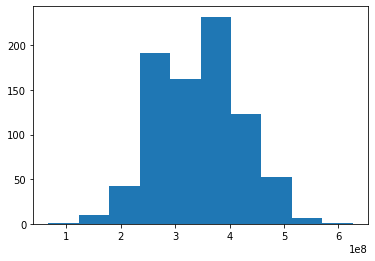

In [85]:
plt.hist(y11)
plt.show()

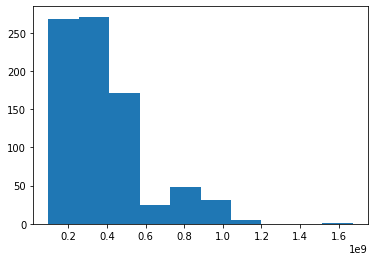

In [86]:
plt.hist(prehammer)
plt.show()

### 몬테카를로 모델에 의해 나온 계수들로 hammer price 계산

### scale을 잘못한거같긴 한데 방법을 모르겠습니다ㅠ
intercept term은 어디?

In [87]:
data.head()

,PC1,PC2,Claim_price,Auction_count,Hammer_price,Final_First_auction_data,ad_si_0,ad_si_1,ad_si_2,ad_si_3,Appr_0,Appr_1,Appr_2,서울,transformed_Hammer_price,skyscraper
0,2.82322,-1.43572,1766037301,2,760000000,35,0,1,0,0,0,0,1,0,175.39407,30
1,1.27894,-2.64661,152946867,2,971889999,35,0,1,0,0,0,0,1,0,182.98579,51
2,-0.53006,2.63166,11326510,3,93399999,77,0,0,0,1,0,0,1,0,121.88877,30
3,-0.70646,0.08109,183581724,2,256899000,105,0,0,0,1,0,0,1,0,145.38769,30
4,-0.53385,0.98682,45887671,2,158660000,28,0,0,0,1,0,0,1,0,133.70034,30


In [88]:
tdat.head()

,PC1,PC2,Claim_price,Auction_count,Hammer_price,Final_First_auction_data,ad_si_0,ad_si_1,ad_si_2,Appr_0,Appr_1,서울,skyscraper,transformed_Hammer_price
0,-0.01812,-1.28331,1087000000,7,0,1058,0,0,0,0,0,0,30,136.40678
1,-0.13874,-1.14894,1087000000,6,0,1030,0,0,0,0,0,0,30,138.33211
2,-0.02124,-1.27999,1087000000,7,0,1058,0,0,0,0,0,0,30,136.36724
3,-0.02124,-1.27999,1087000000,7,0,1058,0,0,0,0,0,0,30,136.36724
4,-0.02124,-1.27999,1087000000,7,0,1058,0,0,0,0,0,0,30,136.36724


In [89]:
for i in X1.columns:
    m1 = np.mean(X1[i])
    s1 = np.std(X1[i])
    X1[i] = X1[i].apply(lambda x : (x-m1)/s1)

In [90]:
X11 = X1[['PC2','Claim_price','Auction_count','Final_First_auction_data','ad_si_0','ad_si_1','ad_si_2','Appr_0','Appr_1','서울','skyscraper']]

In [91]:
X11['a'] = -1.632591
X11['b'] = -0.000502
X11['c'] = -2.944793
X11['d'] = 0.005051
X11['e'] = 24.100104
X11['f'] = 9.486778
X11['g'] = 30.645450
X11['h'] = 7.222578
X11['i'] = 29.947207
X11['j'] = 14.348497
X11['k'] = 1.803480
X11['l'] = 87.368982

In [92]:
hammer2=[]
for i in range(820):
    hammer2.append((X11['PC2'][i]*X11['a'][i])+(X11['Claim_price'][i]*X11['b'][i])+(X11['Auction_count'][i]*X11['c'][i])+(X11['Final_First_auction_data'][i]*X11['d'][i])+(X11['ad_si_0'][i]*X11['e'][i])+(X11['ad_si_1'][i]*X11['f'][i])+(X11['ad_si_2'][i]*X11['g'][i])+(X11['Appr_0'][i]*X11['h'][i])+(X11['Appr_1'][i]*X11['i'][i])+(X11['서울'][i]*X11['j'][i])+(X11['skyscraper'][i]*X11['k'][i]) + X11['l'][i])

In [93]:
hammer2

[33.143870702671116,
 35.951509656223756,
 33.1369853528407,
 33.1369853528407,
 33.1369853528407,
 33.1369853528407,
 35.951509656223756,
 42.812976663258844,
 46.732723712759274,
 46.82126575147772,
 46.88302755906691,
 43.60176250742134,
 49.84510322548929,
 42.677957427536036,
 49.03342511541582,
 45.88537566128438,
 46.13863080988899,
 37.948863810327076,
 44.181866338053176,
 46.59047526829112,
 31.29912446351502,
 45.56909179947598,
 46.98438357236721,
 46.99567969260047,
 46.89218493848737,
 47.652465129284884,
 45.955374140217565,
 47.88966852024911,
 42.72036890222666,
 47.63152046989057,
 46.649945144698926,
 46.7541125181527,
 48.56493895884744,
 46.27325200072817,
 46.739230873987886,
 47.26527159820683,
 43.28415177515226,
 46.71887335713312,
 47.01424963430298,
 45.980922005393936,
 45.59241744553375,
 50.33411442516605,
 47.776487609240796,
 46.97534046303945,
 47.59947902696501,
 47.07367226826674,
 44.619897237192916,
 57.57663888533679,
 51.12351901795304,
 45.549236

In [94]:
prehammer2 = inv_boxcox(hammer2, lambda_boxcox)

In [95]:
pd.options.display.float_format = '{:.5f}'.format
prehammer2

array([7.69529281e+04, 1.16594846e+05, 7.68717702e+04, 7.68717702e+04,
       7.68717702e+04, 7.68717702e+04, 1.16594846e+05, 2.89265744e+05,
       4.59737800e+05, 4.64387569e+05, 4.67654125e+05, 3.18461016e+05,
       6.48481278e+05, 2.84499389e+05, 5.93959588e+05, 4.17167657e+05,
       4.29531494e+05, 1.54115615e+05, 3.41464870e+05, 4.52348903e+05,
       5.76060350e+04, 4.02144563e+05, 4.73056288e+05, 4.73661566e+05,
       4.68140081e+05, 5.09981477e+05, 4.20554915e+05, 5.23656083e+05,
       2.85989466e+05, 5.08788470e+05, 4.55425851e+05, 4.60857459e+05,
       5.64268715e+05, 4.36226966e+05, 4.60078196e+05, 4.88299752e+05,
       3.06423455e+05, 4.59013972e+05, 4.74657998e+05, 4.21796881e+05,
       4.03236875e+05, 6.83296587e+05, 5.17093669e+05, 4.72572198e+05,
       5.06967890e+05, 4.77858263e+05, 3.59738073e+05, 1.41148385e+06,
       7.42779423e+05, 4.01216723e+05, 4.42698197e+06, 4.59537188e+05,
       5.55998082e+05, 3.32992228e+06, 4.67954558e+05, 4.62607375e+05,
      